In [339]:
from aicsimageio import AICSImage
from tifffile import imsave
from pathlib import Path
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import ball, binary_closing, remove_small_objects, dilation, erosion, disk
from aicssegmentation.core.pre_processing_utils import  intensity_normalization, edge_preserving_smoothing_3d
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import topology_preserving_thinning, hole_filling
import matplotlib.pyplot as plt
from itkwidgets import view   
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
plt.rcParams["figure.figsize"] = [16, 12]
from aicssegmentation.core.MO_threshold import MO
import warnings
warnings.filterwarnings('ignore')

In [360]:
filename = "//allen/aics/microscopy/PRODUCTION/PIPELINE_8_1/5500000635_EE_1-01/aligned_split/5500000635_EE_1-01_AcquisitionBlock5_pt5_Scene-11_aligned.ome.tiff"
# filename = "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-imgs/raw/5500000639_EE_1-01_AcquisitionBlock7_pt7_Scene-4_aligned.ome.tiff"

reader = AICSImage(filename)
IMG = reader.data.astype(np.float32)
#IMG = np.transpose(IMG, (0,2,1,3,4))
#IMG = np.concatenate([IMG, IMG], 2)
# for regular images
# filename = "//allen/aics/assay-dev/users/Sandi/golgi-segmentations/all-raw-imgs/20210223_N02_001-alignV2-Scene-01-P1-C04.tif
# reader = AICSImage(filename) 
# IMG = reader.data.astype(np.float32)


print(IMG.shape)

Attempted file (//allen/aics/microscopy/PRODUCTION/PIPELINE_8_1/5500000635_EE_1-01/aligned_split/5500000635_EE_1-01_AcquisitionBlock5_pt5_Scene-11_aligned.ome.tiff) load with reader: aicsimageio.readers.bfio_reader.OmeTiledTiffReader failed with error: No module named 'bfio'


(1, 2, 40, 1200, 1800)


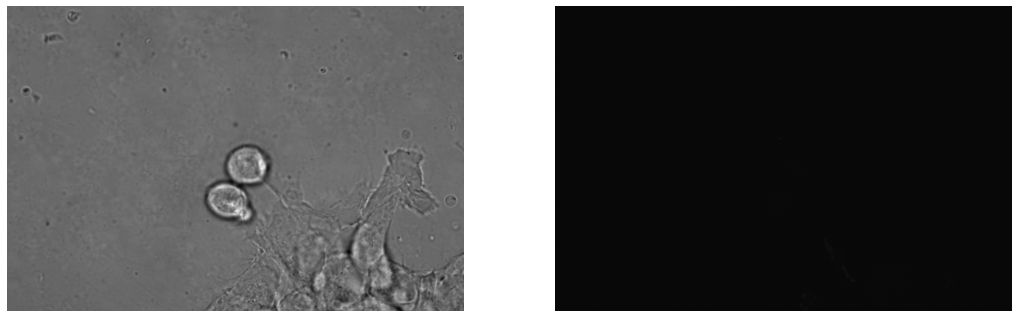

In [361]:
N_CHANNELS = IMG.shape[1] 
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS==1:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [362]:
#####################
structure_channel = 1
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
#view(single_fluorescent_view(struct_img0))

In [363]:
print(struct_img0.shape)

(40, 1200, 1800)


In [364]:
img_norm = intensity_normalization(struct_img0.copy(), scaling_param=[50, 55])# original: [2,20] workflow: [2,70]
img_smooth = edge_preserving_smoothing_3d(img_norm, numberOfIterations=30)

In [365]:
th = 2.4 * threshold_otsu(img_smooth) # original at 1.4. v3 & v5 at 4.0. v5.1: 1.8 v6&7:4.8
overall_shape = dilation(
    remove_small_objects(img_smooth > th, min_size=1, connectivity=1, in_place=False), #min_size = 10
    ball(1)
)
fixed_shape = erosion(
    hole_filling(overall_shape, hole_min=0, hole_max=5, fill_2d=True), #, hole_min= 0 hole_max = 5
    ball(1)
)

In [366]:
# 2d spot filter
s2 = np.zeros_like(fixed_shape)
for z in range(img_smooth.shape[0]):
    zslice = dot_2d(img_smooth[z,], 2)
    s2[z, :, :] = zslice > 0.04 #increase value,get rid of background noise (less spottiness) original:0.02 v5:0.25 v5.1:0.05
fixed_shape = np.logical_or(s2, fixed_shape)

In [367]:
# 2d erosion for thinning
for z in range(fixed_shape.shape[0]):
    zslice= fixed_shape[z,]
    zslice = erosion(zslice, disk(1))
    fixed_shape[z, :, :] = zslice


response_vessel = vesselness3D(img_smooth, sigmas=[1], tau=1, whiteonblack=True)

seg = np.logical_or(response_vessel > 0.5, fixed_shape) # response_vessel > 0.28 v5:0.5

seg = hole_filling(seg, hole_min=0, hole_max=15, fill_2d=True)# hole_min=0 # hole_max=15

In [368]:
out=seg.astype(np.uint8)
out[out>0]=255
imsave("golgi-50ms-b5-sc11v2.tiff", out) 
# imsave("golgi-200ms-ex7v9.3.tiff", seg) 

In [350]:
# EXTRA STEPS (NOT CURRENTLY NEEDED)

# MASK OBJECT THRESH: applying mask object threshold
# bw2, object_for_debug = MO(seg, global_thresh_method='tri', object_minArea=200, return_object=True) # minArea: 1200 #v5: 200

# TOPOLOGY THINNING
# thin_dist_preserve=2 #original 0.01
# thin_dist=2
# bw_thin = topology_preserving_thinning(bw2>0, thin_dist_preserve, thin_dist)

# MINIMUM AREA
# minArea = 1 # original 1
# seg2 = remove_small_objects(bw2>0, min_size=minArea, connectivity=1, in_place=True)